In [5]:
import numpy as np
import pickle
import pandas as pd
import h5py
import pandas as pd
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import EfficientFCParameters
import multiprocessing
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np


In [6]:

def gini_impurity(y):
    """Calcular la impureza Gini de un array de etiquetas"""
    if len(y) == 0:
        return 0
    # Proporción de cada clase
    clases = np.unique(y)
    probabilities = [np.mean(y == c) for c in clases]
    gini = 1 - sum(p ** 2 for p in probabilities)
    return gini

def entropy(y):
    """Calcular la entropía de un array de etiquetas"""
    if len(y) == 0:
        return 0
    # Proporción de cada clase
    clases = np.unique(y)
    probabilities = [np.mean(y == c) for c in clases]
    # Usamos log2 para calcular la entropía
    entropy_value = -sum(p * np.log2(p) for p in probabilities if p > 0)
    return entropy_value


def information_gain(y, left_indices, right_indices, impurity_function=gini_impurity):
    """Calcular la ganancia de información de una división utilizando impureza Gini o entropía"""
    parent_impurity = impurity_function(y)
    
    # Subconjuntos izquierdo y derecho
    left_impurity = impurity_function(y[left_indices])
    right_impurity = impurity_function(y[right_indices])
    
    # Peso de los subconjuntos izquierdo y derecho
    left_weight = len(left_indices) / len(y)
    right_weight = len(right_indices) / len(y)
    
    # Impureza ponderada de los hijos
    weighted_impurity = left_weight * left_impurity + right_weight * right_impurity
    
    # Ganancia de información
    info_gain = parent_impurity - weighted_impurity
    return info_gain


In [7]:
class DecisionTree:
    """Decision Tree tomando en cuenta que el dataset es discreto o está discretizado"""
    def __init__(self, max_depth=None, impurity_function=gini_impurity):
        self.max_depth = max_depth
        self.impurity_function = impurity_function
        self.tree = None
    def fit(self, X, y):
        """Ajustar el árbol de decisión a los datos"""
        self.tree = self._build_tree(X, y, depth=0)
    
    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        # Si ya es un nodo hoja o alcanzamos la profundidad máxima ya no dividimos
        if n_labels == 1 or (self.max_depth and depth == self.max_depth):
            return np.unique(y)[0]

        # Buscamos el atributo que gane más información
        best_gain = -1 # Valor de inicio
        best_split = None
        best_left_indices = None
        best_right_indices = None

        # Por cada caracterísitca o dimensión
        for feature in range(n_features):
            valores = np.unique(X[:, feature]) 
            # Sacamos las ramas
            for valor in valores: 
                left_indices = np.where(X[:, feature] == valor)[0]
                right_indices = np.where(X[:, feature] != valor)[0]

                
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue
                
                gain = information_gain(y, left_indices, right_indices, self.impurity_function)

                if gain > best_gain:
                    best_gain = gain
                    best_split = {
                        "feature": feature,
                        "value": valor 
                    }
                    best_left_indices = left_indices
                    best_right_indices = right_indices
             # Si no se encontró una mejor división, retornamos la clase mayoritaria
        if best_gain == -1:
            return np.bincount(y).argmax()
            
        # Construir recursivamente las ramas
        left_subtree = self._build_tree(X[best_left_indices], y[best_left_indices], depth + 1)
        right_subtree = self._build_tree(X[best_right_indices], y[best_right_indices], depth + 1)
        return {
        "feature": best_split["feature"],
        "value": best_split["value"],
        "left": left_subtree,
        "right": right_subtree
        }
        
    def predict_one(self, x, node=None):
        """Predecir una muestra individual"""
        if node is None:
            node = self.tree

        if not isinstance(node, dict):
            return node

        feature = node["feature"]
        value = node["value"]

        if x[feature] == value:
            return self.predict_one(x, node["left"])
        else:
            return self.predict_one(x, node["right"])
    
    def predict(self, X):
        """Predecir múltiples muestras"""
        return np.array([self.predict_one(x) for x in X])

    def print_tree(self, node=None, depth=0):
            """Imprimir el árbol de decisión"""
            if node is None:
                node = self.tree
            indent = "  " * depth
            if not isinstance(node, dict):
                print(indent + "Predict:", node)
                return
        
            feature = node["feature"]
            value = node["value"]
        
            print(f"{indent}¿X[{feature}] == {value}?")
            print(f"{indent}-> Sí:")
            self.print_tree(node["left"], depth + 1)
        
            print(f"{indent}-> No:")
            self.print_tree(node["right"], depth + 1)


In [ ]:
with h5py.File("train.h5", "r") as f_pd:
    y_data = f_pd['y'][:]  
y_df = pd.Series(y_data)  


x_df = pd.read_pickle("all_features.pkl")
x_df.head()
print("Shape de y_df", y_df.shape)
print("Shape de X_df", x_df.shape)

value_counts = y_df.value_counts()

print("Cantidad de 0 y 1 en y_df:")
print(value_counts)


Shape de y_df (204,)
Shape de X_df (204, 777)
Cantidad de 0 y 1 en y_df:
0    149
1     55
Name: count, dtype: int64


Para la discretización de nuestro dataset usaremos k-means, debido a que la elección de los grupos que ahora tendrá nuestro dataset será complicado, veremos la varianza y de acuerdo a ello asignaremos más grupos

In [9]:
def calculate_clusters_based_on_variance(column):
    variance = np.var(column)
    
    if variance < 1:
        return 2 
    elif variance < 10:
        return 3  
    else:
        return 4 
    
def discretize_with_kmeans(column):
    n_clusters = calculate_clusters_based_on_variance(column)
    
    # Reshape para aplicar KMeans (n_samples, n_features)
    column_reshaped = column.values.reshape(-1, 1)
    
    # Ajustamos KMeans a la columna con el número de clusters calculado
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(column_reshaped)
    
    # Asignar a cada valor el índice del cluster
    return kmeans.labels_

In [10]:
x_df_discretized = x_df
for col in x_df.columns:
    n_clusters = 3  
    x_df_discretized[col] = discretize_with_kmeans(x_df[col])

x_df_discretized.head()



/home/marce/Documentos/Ciclo6/Machine Learning/Proyecto1/project-1-classification-2025-1-b/venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/marce/Documentos/Ciclo6/Machine Learning/Proyecto1/project-1-classification-2025-1-b/venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/marce/Documentos/Ciclo6/Machine Learning/Proyecto1/project-1-classification-2025-1-b/venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/marce/Documentos/Ciclo6/Machine

,valor__variance_larger_than_standard_deviation,valor__has_duplicate_max,valor__has_duplicate_min,valor__has_duplicate,valor__sum_values,valor__abs_energy,valor__mean_abs_change,valor__mean_change,valor__mean_second_derivative_central,valor__median,...,valor__fourier_entropy__bins_5,valor__fourier_entropy__bins_10,valor__fourier_entropy__bins_100,valor__permutation_entropy__dimension_3__tau_1,valor__permutation_entropy__dimension_4__tau_1,valor__permutation_entropy__dimension_5__tau_1,valor__permutation_entropy__dimension_6__tau_1,valor__permutation_entropy__dimension_7__tau_1,valor__query_similarity_count__query_None__threshold_0.0,valor__mean_n_absolute_max__number_of_maxima_7
0,0,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,0,1
1,0,1,1,0,1,1,1,1,0,0,...,0,0,1,1,1,1,1,1,0,1
2,0,1,1,0,1,1,1,1,0,1,...,0,0,1,0,0,0,0,2,0,1
3,0,1,1,0,1,1,1,1,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0,1,1,0,1,1,1,1,0,1,...,1,1,1,0,0,1,1,2,0,1


In [11]:
X_train, X_test, y_train, y_test = train_test_split(x_df_discretized, y_df, test_size=0.3, random_state=42)

tree = DecisionTree(max_depth=10, impurity_function=gini_impurity)

# Ajustar el árbol a los datos de entrenamiento
tree.fit(X_train.values, y_train.values)

# Predecir las etiquetas para el conjunto de prueba
y_pred = tree.predict(X_test.values)

# Calcular las métricas de rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Reporte completo de métricas
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.6129032258064516
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        46
           1       0.30      0.38      0.33        16

    accuracy                           0.61        62
   macro avg       0.53      0.54      0.53        62
weighted avg       0.64      0.61      0.63        62

Confusion Matrix:
[[32 14]
 [10  6]]


Debido a que la clase minorítaria no está siendo reconocida adecuadamente, vamos a usar ensamblaje (random forest personalizado)

Mejor profundidad: 1 con Accuracy: 0.7419354838709677


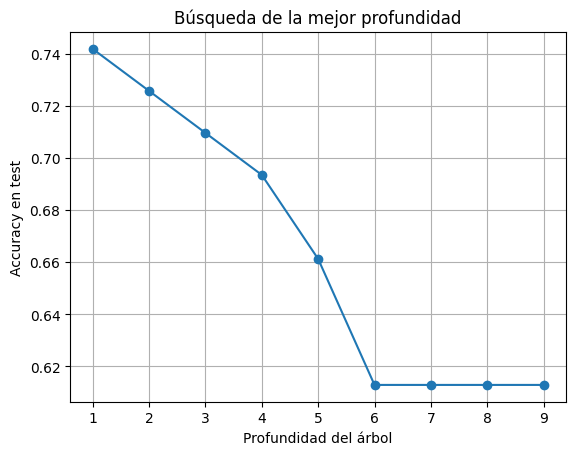

In [12]:
best_depth = None
best_accuracy = 0
depth_accuracies = []

for depth in range(1, 10):  
    tree = DecisionTree(max_depth=depth, impurity_function=gini_impurity)
    tree.fit(X_train.values, y_train.values)
    y_pred = tree.predict(X_test.values)
    accuracy = accuracy_score(y_test, y_pred)
    depth_accuracies.append((depth, accuracy))
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth

print(f"Mejor profundidad: {best_depth} con Accuracy: {best_accuracy}")

import matplotlib.pyplot as plt

depths, accuracies = zip(*depth_accuracies)
plt.plot(depths, accuracies, marker='o')
plt.xlabel("Profundidad del árbol")
plt.ylabel("Accuracy en test")
plt.title("Búsqueda de la mejor profundidad")
plt.grid(True)
plt.show()

/home/marce/Documentos/Ciclo6/Machine Learning/Proyecto1/project-1-classification-2025-1-b/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marce/Documentos/Ciclo6/Machine Learning/Proyecto1/project-1-classification-2025-1-b/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marce/Documentos/Ciclo6/Machine Learning/Proyecto1/project-1-classification-2025-1-b/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precis

Mejor profundidad: 5 con Recall (clase 1): 0.3750


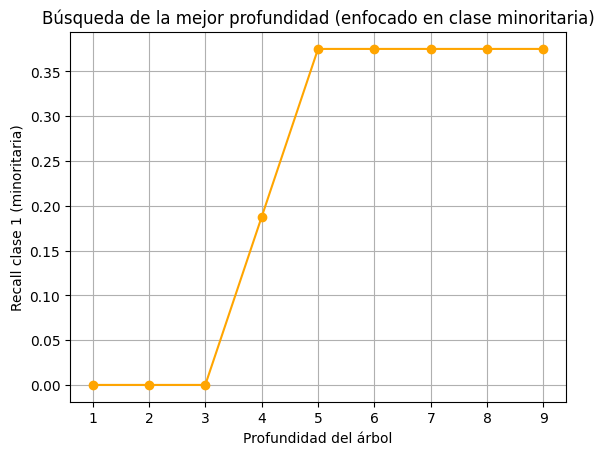

In [13]:
from sklearn.metrics import classification_report

best_depth = None
best_recall = 0
depth_recalls = []

for depth in range(1, 10):  
    tree = DecisionTree(max_depth=depth, impurity_function=gini_impurity)
    tree.fit(X_train.values, y_train.values)
    y_pred = tree.predict(X_test.values)

    report = classification_report(y_test, y_pred, output_dict=True)
    recall_minority = report['1']['recall']  # Recall de la clase 1 (minoritaria)
    depth_recalls.append((depth, recall_minority))

    if recall_minority > best_recall:
        best_recall = recall_minority
        best_depth = depth

print(f"Mejor profundidad: {best_depth} con Recall (clase 1): {best_recall:.4f}")

import matplotlib.pyplot as plt

depths, recalls = zip(*depth_recalls)
plt.plot(depths, recalls, marker='o', color='orange')
plt.xlabel("Profundidad del árbol")
plt.ylabel("Recall clase 1 (minoritaria)")
plt.title("Búsqueda de la mejor profundidad (enfocado en clase minoritaria)")
plt.grid(True)
plt.show()



In [35]:

class DecisionTreeEnsemble:
    def __init__(self, n_estimators=3, max_depth=None, impurity_function=gini_impurity):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.impurity_function = impurity_function
        self.trees = []
        self.accuracies = []
    def _bootstrap_sample(self, X, y):
        """Tomar una muestra con reemplazo del conjunto de entrenamiento"""
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def calculate_where_fail(self, model, X, y):
        """Retornar índices donde el modelo falló"""
        preds = model.predict(X)
        return np.where(preds != y)[0]


    def increment_weight(self, X, y, fail_indices, l=2):
        """Replicar l veces las muestras mal clasificadas"""
        X_fail = X[fail_indices]
        y_fail = y[fail_indices]
        X_augmented = np.concatenate([X] + [X_fail] * l)
        y_augmented = np.concatenate([y] + [y_fail] * l)
        return X_augmented, y_augmented

    def fit(self, X, y):
        self.trees = []
        self.accuracies = [] 
        X_current = X
        y_current = y

        for i in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth, impurity_function=self.impurity_function)
            X_sample, y_sample = self._bootstrap_sample(X_current, y_current)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

            # identificar fallos y reponderar para la próxima iteración
            fail_indices = self.calculate_where_fail(tree, X, y)
            if len(fail_indices) > 0:
                X_current, y_current = self.increment_weight(X, y, fail_indices, l=2)  
            y_pred = tree.predict(X)
            acc = accuracy_score(y, y_pred)
            self.accuracies.append(acc)
            print(f"[Árbol {i+1}] Accuracy en entrenamiento: {acc:.4f}")
            print(classification_report(y, y_pred))

    def predict(self, X):
        # Cada árbol hace su predicción
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Votación por mayoría
        final_preds = []
        for sample_preds in tree_preds.T:  
            majority_vote = Counter(sample_preds).most_common(1)[0][0]
            final_preds.append(majority_vote)
        return np.array(final_preds)
    def best_tree(self):
        """Retorna el árbol con el mayor accuracy"""
        best_accuracy_index = np.argmax(self.accuracies)  
        best_tree = self.trees[best_accuracy_index]  
        best_accuracy = self.accuracies[best_accuracy_index] 
        print(f"El mejor árbol tiene un accuracy de: {best_accuracy:.4f}")
        return best_tree
    def saveBestTree(self, filename="best_tree.pkl"):
        """Guarda el árbol con el mejor accuracy en un archivo usando pickle sin numpy para ya no volver a correr"""
        best_tree = self.best_tree()  
        with open(filename, 'wb') as f:
            pickle.dump(best_tree, f) 
        print(f"El mejor árbol ha sido guardado en {filename}")


In [15]:
x_df_discretized.head()

,valor__variance_larger_than_standard_deviation,valor__has_duplicate_max,valor__has_duplicate_min,valor__has_duplicate,valor__sum_values,valor__abs_energy,valor__mean_abs_change,valor__mean_change,valor__mean_second_derivative_central,valor__median,...,valor__fourier_entropy__bins_5,valor__fourier_entropy__bins_10,valor__fourier_entropy__bins_100,valor__permutation_entropy__dimension_3__tau_1,valor__permutation_entropy__dimension_4__tau_1,valor__permutation_entropy__dimension_5__tau_1,valor__permutation_entropy__dimension_6__tau_1,valor__permutation_entropy__dimension_7__tau_1,valor__query_similarity_count__query_None__threshold_0.0,valor__mean_n_absolute_max__number_of_maxima_7
0,0,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,0,1
1,0,1,1,0,1,1,1,1,0,0,...,0,0,1,1,1,1,1,1,0,1
2,0,1,1,0,1,1,1,1,0,1,...,0,0,1,0,0,0,0,2,0,1
3,0,1,1,0,1,1,1,1,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0,1,1,0,1,1,1,1,0,1,...,1,1,1,0,0,1,1,2,0,1


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(x_df_discretized.values, y_df.values, test_size=0.2, random_state=42, stratify=y_df)

# Entrenamiento del ensamble
ensemble = DecisionTreeEnsemble(n_estimators=20, max_depth=6, impurity_function=gini_impurity)
ensemble.fit(X_train, y_train)

# Predicción
y_pred = ensemble.predict(X_test)

# Evaluación
print("\nResultados del Ensemble:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

ensemble.best_tree()
ensemble.saveBestTree("best_trees-depht6.pkl")

[Árbol 1] Accuracy en entrenamiento: 0.8405
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       119
           1       0.71      0.68      0.70        44

    accuracy                           0.84       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.84      0.84      0.84       163

[Árbol 2] Accuracy en entrenamiento: 0.8896
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       119
           1       0.74      0.91      0.82        44

    accuracy                           0.89       163
   macro avg       0.85      0.90      0.87       163
weighted avg       0.90      0.89      0.89       163

[Árbol 3] Accuracy en entrenamiento: 0.9080
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       119
           1       0.87      0.77      0.82        44

    accuracy                           0.91       

Los resultados con el ensamblaje no fueron adecuados, de hecho los resultados de los àrboles por separado son mejores. Lo que presentan de diferente estos modelos en el ensamblaje con el Decision tree es la muestra aleatoria de los datos, por esta razón aplicaremos Cross Validation

In [17]:
def cross_validate(model_class, X, y, k=5, **model_kwargs):
    # Separamos la data en 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []

    # Iteramos en los conjuntos de entrenamiento y validación
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = model_class(**model_kwargs)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        scores.append(acc)

    return np.mean(scores)

def grid_search(X, y, param_grid):
    best_score = -1
    best_params = None
    # Retornamos el mejor el que tuvo un mejor desempeño
    for depth in param_grid["max_depth"]:
        score = cross_validate(DecisionTree, X, y, k=5, max_depth=depth)
        print(f"max_depth={depth} -> Accuracy={score:.4f}")

        if score > best_score:
            best_score = score
            best_params = {"max_depth": depth}

    return best_params, best_score


In [37]:
param_grid = {"max_depth": [5, 6, 7, 8, 9, 10]}
best_params, best_score = grid_search(x_df_discretized.values, y_df.values, param_grid)

print("Mejores parámetros:", best_params)
print("Mejor precisión:", best_score)


max_depth=5 -> Accuracy=0.7010
max_depth=6 -> Accuracy=0.7010
max_depth=7 -> Accuracy=0.6912
max_depth=8 -> Accuracy=0.6912
max_depth=9 -> Accuracy=0.6815
max_depth=10 -> Accuracy=0.6815
Mejores parámetros: {'max_depth': 5}
Mejor precisión: 0.7009756097560975
